In [22]:
!pip install sentence-transformers
!pip install pymorphy2
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import json
import pandas as pd
import gensim
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt

import json
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.models as models
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import gensim.downloader as api
import sentence_transformers
from sentence_transformers import SentenceTransformer
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from google.colab import files

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

import re


def sent_preprocess(text:str):
    preprocessed_text = sent_tokenize(text)
    for i in range(len(preprocessed_text)):
        res = re.sub(r'([^\w\s])|([0-9]+)', '', preprocessed_text[i])
        # res = re.sub(r'', '' ,  res)
        preprocessed_text[i] = (preprocessed_text[i], res)
    
    preprocessed_text = list(filter(lambda sentence: sentence[0] != '', preprocessed_text))
    
    return preprocessed_text



In [25]:
match_df_path = '/content/drive/MyDrive/4th_coursre/Диплом/Colab/match.json'
unmatch_df_path = '/content/drive/MyDrive/4th_coursre/Диплом/Colab/unmatch.json'

In [26]:
match_df = pd.read_json(match_df_path)
unmatch_df = pd.read_json(unmatch_df_path)

# Трансформер: нахождение cos_sim

In [27]:
rubert = SentenceTransformer('DeepPavlov/rubert-base-cased')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
rubert = SentenceTransformer('/content/drive/MyDrive/4th_coursre/Диплом/Colab/rubert-base-cased')

In [29]:
def get_train_test_dfs_for_f1(df_match, df_unmatch): 
    df_match = shuffle(df_match)
    df_unmatch = shuffle(df_unmatch)
    
    df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
    df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
    return (df_train_f1, df_test_f1)

In [30]:
def compare_sentences_from_texts(text_1, text_2, top_num=5, count_of_comparings=3):
    sentences_rp = sent_preprocess(text_1)
    sentences_proj = sent_preprocess(text_2)

    def comp(e):
        return e['cos_sim']

    top_number = top_num
    sentences_proj_embeddings = []

    if len(sentences_rp) > count_of_comparings:
        sentences_rp = sentences_rp[:count_of_comparings]

    for sentence_proj in sentences_proj:
        sentences_proj_embeddings += [rubert.encode(sentence_proj[1], convert_to_tensor=True)]

    for sentence_rp in sentences_rp:
        sentence_rp_embedding = rubert.encode(sentence_rp[1], convert_to_tensor=True)
        sim = []
        print(f'RP sentence: {sentence_rp[0]}')
        for i in range(len(sentences_proj_embeddings)):
            sim += [{ 'proj': sentences_proj[i][0], 
                      'cos_sim': float(sentence_transformers.util.cos_sim( sentence_rp_embedding, sentences_proj_embeddings[i]))
                    }]

        sim.sort(key=comp, reverse=True)
        print(f'top {top_number} similarities:')
        count = top_number
        if(len(sim) < top_number):
            count = len(sim)
          
        for i in range(count):
            print('proj: {}\nsim: {}\n'.format(sim[i]['proj'], round(sim[i]['cos_sim'], 3)))
        print('-'*len(sentences_rp[0][0]))

In [31]:
df_train_f1, df_test_f1 = get_train_test_dfs_for_f1(match_df, unmatch_df)

texts_rp = df_train_f1['text_rp'].reset_index().drop(labels='index', axis=1).squeeze()
texts_proj = df_train_f1['text_proj'].reset_index().drop(labels='index', axis=1).squeeze()

In [32]:
df_test_f1

,id_rp,id_proj,name_rp,name_proj,text_rp,text_proj,need_match
14,4776,8,Web-технологии,"Разработка ИС ""Расписание"" / ""Деканат""",Курс «Web-технологии» охватывает широкий спект...,"Разработка ИС ""Расписание"" / ""Деканат"". Информ...",True
23,1916,41,Разработка программного обеспечения для робот...,Разработка подводного телеуправляемого робота ...,Цели изучения курса состоят в формировании зн...,Разработка подводного телеуправляемого робота ...,True
8,991,30,Машинное обучение,Разработка системы детектирования и идентифика...,Данный курс знакомит слушателей с основными ме...,Разработка системы детектирования и идентифика...,True
15,4770,48,Машинное обучение,Разработка рекомендательной машины,Дисциплина посвящена знакомству с основными по...,Разработка рекомендательной машины. Рекомендат...,True
5,105,41,Системы управления манипуляторными роботами,Разработка подводного телеуправляемого робота ...,Дисциплина включает изложение основ теории ман...,Разработка подводного телеуправляемого робота ...,True
13,4776,34,Web-технологии,Разработка модулей «Кафедра» и «Деканат-2» для...,Курс «Web-технологии» охватывает широкий спект...,Разработка модулей «Кафедра» и «Деканат-2» для...,True
2,1009,4,РАЗРАБОТКА ПРИЛОЖЕНИЙ В РАСПРЕДЕЛЕННОЙ СРЕДЕ,Разработка модулей обработки данных для библио...,Дисциплина посвящена изучению основных принцип...,Разработка модулей обработки данных для библио...,True
1,1005,40,АНАЛИЗ ДАННЫХ В ИСКУССТВЕННОМ ИНТЕЛЛЕКТЕ,Роботизированная система машинного творчества ...,Освещаемые в курсе теоретические и прикладные ...,Роботизированная система машинного творчества ...,True
10,998,45,Разработка в ядре Linux,Разработка САПР на основе платформы Beremiz дл...,дисциплина посвящена изучению проектирования к...,Разработка САПР на основе платформы Beremiz дл...,True
6,1040,26,Управление и информатика в технических системах,Программно-аппаратное конфигурирование сети ла...,В рамках данной дисциплины рассматриваются осн...,Программно-аппаратное конфигурирование сети ла...,True


In [33]:
compare_sentences_from_texts(texts_rp[0], texts_rp[2], top_num=3, count_of_comparings=2)

RP sentence: Данный курс знакомит слушателей с основами управления беспилотными автомобилями.
top 3 similarities:
proj: Решение задачи обучения в интеллектуальных системах.
sim: 0.617

proj: Решение задачи планирования действий в интеллектуальных системах.
sim: 0.558

proj: Студент должен показать умение анализировать профессиональную информацию, выделять в ней главное, структурировать, оформлять и программировать в рамках декларативной парадигмы, способен разрабатывать алгоритмы и программные средства для решения задач в области создания и применения искусственного интеллекта.
sim: 0.545

--------------------------------------------------------------------------------
RP sentence: Рассматриваются основные компоненты таких сиcтем: модели и методы восприятия информации при помощи сенсоров или человеко-машинного интерфейса; методы определения собственного положения на известной и неизвестной карте; методы планирования пути (в том числе на графах и не на графах); фреймворк, подходящий для

In [34]:
from joblib import Memory

mem = Memory(cachedir='/content/drive/MyDrive/4th_coursre/Диплом/Colab/cache')

<ipython-input-34-c2cffdfde726>:3: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/content/drive/MyDrive/4th_coursre/Диплом/Colab/cache'", use "location='/content/drive/MyDrive/4th_coursre/Диплом/Colab/cache'" instead.
  mem = Memory(cachedir='/content/drive/MyDrive/4th_coursre/Диплом/Colab/cache')


In [35]:
from functools import lru_cache

def compare_sentences_from_texts(text_1, text_2):
    sentences_rp = sent_preprocess(text_1)
    sentences_proj = sent_preprocess(text_2)

    def comp(e):
        return e['cos_sim']

    sentences_proj_embeddings = []

    for sentence_proj in sentences_proj:
        sentences_proj_embeddings += [rubert.encode(sentence_proj[1], convert_to_tensor=True)]
    

    max_sims = []
    for sentence_rp in sentences_rp:
        sentence_rp_embedding = rubert.encode(sentence_rp[1], convert_to_tensor=True)
        sim = []
        # print(f'RP sentence: {sentence_rp[0]}')
        for i in range(len(sentences_proj_embeddings)):
            sim += [{ 'proj': sentences_proj[i][0], 
                      'cos_sim': float(sentence_transformers.util.cos_sim( sentence_rp_embedding, sentences_proj_embeddings[i]))
                    }]

        # sim.sort(key=comp, reverse=True)
        max_sims.append(max(sim, key=comp)['cos_sim'])

    # print(max_sims)
    return np.mean(max_sims)

        

In [36]:
compare_sentences_from_texts(texts_rp[0], texts_proj[2])


0.536438563808066

In [37]:
def get_shuffled_dataframe(df_match, df_unmatch, need_shuffle=True):
    df_match = shuffle(df_match)
    df_unmatch = shuffle(df_unmatch)
    res = pd.concat([pd.DataFrame(df_match), pd.DataFrame(df_unmatch)], axis=0)
    res = res.reset_index().drop(labels='index', axis=1)
    return res

In [38]:
def maximize_f1_score(texts_rp, texts_proj, df_f1):
    threshold = 0
    thresholds = []
    max_ = 0
    step_max_ = 0
    step = 0.02
    h = step
    steps = np.linspace(0, 1, num=int(1/h))
    steps = np.round(steps, 2)
    sim = []
    for i in range(len(texts_rp)):
      # print(texts_rp[i])
      # print(texts_proj[i])
      sim += [compare_sentences_from_texts(texts_rp[i], texts_proj[i])]

    for i in steps:
        threshold = calc_f1_score(sim, df_f1, h)
        thresholds.append(threshold)
        if threshold > max_:
            max_ = threshold
            step_max_ = h
        h += step
    
    return (steps, thresholds, max_, step_max_)

In [39]:
match_unmatch_df = pd.read_json('/content/drive/MyDrive/4th_coursre/Диплом/Colab/dataset.json')
df_match = match_unmatch_df[ match_unmatch_df['need_match'] == True][:-2]
df_unmatch = match_unmatch_df[match_unmatch_df['need_match'] == False]
df_train_f1, df_test_f1 = get_train_test_dfs_for_f1(df_match, df_unmatch)

# df_train_f1 = get_shuffled_dataframe(df_train_f1)
texts_rp = df_train_f1['text_rp'].reset_index().drop(labels='index', axis=1).squeeze()
texts_proj = df_train_f1['text_proj'].reset_index().drop(labels='index', axis=1).squeeze()

texts_rp_2 = df_test_f1['text_rp'].reset_index().drop(labels='index', axis=1).squeeze()
texts_proj_2 = df_test_f1['text_proj'].reset_index().drop(labels='index', axis=1).squeeze()

In [40]:
df_test_f1

,id_rp,id_proj,name_rp,name_proj,text_rp,text_proj,need_match
20,3524,57,Разработка защищенных программных систем,Стажировка в Digital Security по аудиту защищё...,Дисциплина посвящена изучению современных подх...,Стажировка в Digital Security по аудиту защищё...,True
2,1009,4,РАЗРАБОТКА ПРИЛОЖЕНИЙ В РАСПРЕДЕЛЕННОЙ СРЕДЕ,Разработка модулей обработки данных для библио...,Дисциплина посвящена изучению основных принцип...,Разработка модулей обработки данных для библио...,True
5,105,41,Системы управления манипуляторными роботами,Разработка подводного телеуправляемого робота ...,Дисциплина включает изложение основ теории ман...,Разработка подводного телеуправляемого робота ...,True
3,1011,14,Тестирование и сопровождение программного обес...,Тестирование и документирование стенда виртуал...,"Цели дисциплины охватывают ряд направлений, св...",Тестирование и документирование стенда виртуал...,True
9,985,8,Основы компьютерного дизайна,"Разработка ИС ""Расписание"" / ""Деканат"".",В курсе рассматриваются свойства зрительного в...,"Разработка ИС ""Расписание"" / ""Деканат"". Информ...",True
7,1278,9,Тестирование программного обеспечения,Тестирование конфигураций на платформах: Super...,Дисциплина посвящена изучению теоретических ос...,Тестирование конфигураций на платформах: Super...,True
8,991,30,Машинное обучение,Разработка системы детектирования и идентифика...,Данный курс знакомит слушателей с основными ме...,Разработка системы детектирования и идентифика...,True
21,3514,26,Технологии автоматизации процесса разработки п...,Программно-аппаратное конфигурирование сети ла...,В курсе рассматриваются вопросы организации пр...,Программно-аппаратное конфигурирование сети ла...,True
18,2195,38,Основы гидроакустики,Разработка системы звукоподводной связи на осн...,2 АННОТАЦИЯ ДИСЦИПЛИНЫ «ОСНОВЫ ГИДРОАКУСТИКИ» ...,Разработка системы звукоподводной связи на осн...,True
15,4770,48,Машинное обучение,Разработка рекомендательной машины,Дисциплина посвящена знакомству с основными по...,Разработка рекомендательной машины. Рекомендат...,True


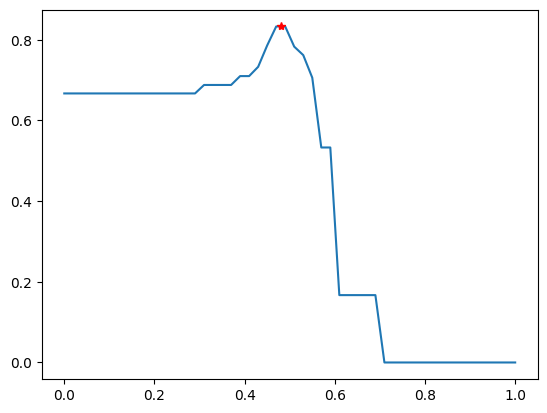

<Figure size 1000x300 with 0 Axes>

Max f1-score is 0.833
Cutoff: 0.48000000000000015


In [41]:
steps, thresholds, max_, step_max_ = maximize_f1_score(texts_rp, texts_proj, df_train_f1)
plt.plot(steps, thresholds)
plt.plot(step_max_, max_, 'r*')
plt.figure(figsize=(10,3))
plt.show()

print(f'Max f1-score is {max_}\nCutoff: {step_max_}')

In [ ]:
def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

In [43]:
sim = []
for i in range(len(texts_rp_2)):
  # print(texts_rp[i])
  # print(texts_proj[i])
  sim += [compare_sentences_from_texts(texts_rp_2[i], texts_proj_2[i])]

In [45]:
calc_f1_score(sim, df_test_f1, 0.48)

0.72

In [47]:
# steps_2, thresholds_2, max_2, step_max_2 = maximize_f1_score(texts_rp_2, texts_proj_2, df_test_f1)
# plt.plot(steps_2, thresholds_2)
# plt.plot(step_max_2, max_2, 'r*')
# plt.figure(figsize=(10,3))
# plt.show()

# print(f'Max f1-score is {max_2}\nCutoff: {step_max_2}')

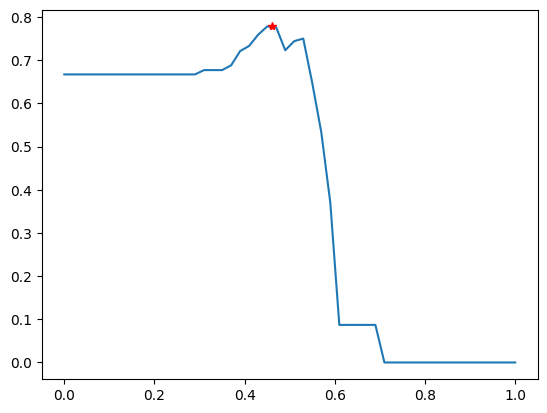

<Figure size 1000x300 with 0 Axes>

Max f1-score is 0.778
Cutoff: 0.46000000000000013


In [46]:
df_f1 = get_shuffled_dataframe(df_match, df_unmatch)
texts_rp = df_f1['text_rp'].reset_index().drop(labels='index', axis=1).squeeze()
texts_proj = df_f1['text_proj'].reset_index().drop(labels='index', axis=1).squeeze()

steps, thresholds, max_, step_max_ = maximize_f1_score(texts_rp, texts_proj, df_f1)
plt.plot(steps, thresholds)
plt.plot(step_max_, max_, 'r*')
plt.figure(figsize=(10,3))
plt.show()

print(f'Max f1-score is {max_}\nCutoff: {step_max_}')

## Leave One Out


In [48]:
def get_train_test_dataframes(df_match, df_unmatch, need_shuffle=True):
  # метод Leave One Out позволяет  
    if need_shuffle:
      df_match = shuffle(df_match)
      df_unmatch = shuffle(df_unmatch)

    df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
    df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
    df_train_f1 = df_train_f1.reset_index().drop(labels='index', axis=1)
    df_test_f1 = df_test_f1.reset_index().drop(labels='index', axis=1)
    return (df_train_f1, df_test_f1)

In [49]:
df_f1 = get_shuffled_dataframe(df_match, df_unmatch)


In [25]:
df_f1

,id_rp,id_proj,name_rp,name_proj,text_rp,text_proj,need_match
0,105,41,Системы управления манипуляторными роботами,Разработка подводного телеуправляемого робота ...,Дисциплина включает изложение основ теории ман...,Разработка подводного телеуправляемого робота ...,True
1,985,8,Основы компьютерного дизайна,"Разработка ИС ""Расписание"" / ""Деканат"".",В курсе рассматриваются свойства зрительного в...,"Разработка ИС ""Расписание"" / ""Деканат"". Информ...",True
2,1009,4,РАЗРАБОТКА ПРИЛОЖЕНИЙ В РАСПРЕДЕЛЕННОЙ СРЕДЕ,Разработка модулей обработки данных для библио...,Дисциплина посвящена изучению основных принцип...,Разработка модулей обработки данных для библио...,True
3,1000,15,АЛГОРИТМЫ БЕСПИЛОТНОГО ТРАНСПОРТА,Разработка системы движения роя дронов в прост...,Данный курс знакомит слушателей с основами упр...,Разработка системы движения роя дронов в прост...,True
4,3490,20,"Спецификация, проектирование и архитектура про...","Построение аналитического решения, включая кор...","Дисциплина «Спецификация, проектирование и арх...","Построение аналитического решения, включая кор...",True
5,4776,8,Web-технологии,"Разработка ИС ""Расписание"" / ""Деканат""",Курс «Web-технологии» охватывает широкий спект...,"Разработка ИС ""Расписание"" / ""Деканат"". Информ...",True
6,5089,31,Глубокое обучение,Определение состояния автомобиля используя видео,Глубокое обучение является передовой областью ...,Определение состояния автомобиля используя вид...,True
7,1098,56,Обработка изображений и компьютерное зрение (...,Практика в проектах по автономному транспорту ...,"Рассматриваются основные задачи, модели, метод...",Практика в проектах по автономному транспорту ...,True
8,4776,11,Web-технологии,Анализ динамики COVID-19 в России,Курс «Web-технологии» охватывает широкий спект...,Анализ динамики COVID-19 в России. · Web...,True
9,1005,40,АНАЛИЗ ДАННЫХ В ИСКУССТВЕННОМ ИНТЕЛЛЕКТЕ,Роботизированная система машинного творчества ...,Освещаемые в курсе теоретические и прикладные ...,Роботизированная система машинного творчества ...,True


In [ ]:
# df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
# df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
# df_train_f1 = df_train_f1.reset_index().drop(labels='index', axis=1)
# df_test_f1 = df_test_f1.reset_index().drop(labels='index', axis=1)

In [ ]:
# df_train_f1

In [ ]:
# df_train_f1.drop(2).index.values.tolist() 

In [50]:
N = len(df_f1)

sim = []
# считаем 1 раз sim
for i in range(len(df_f1)):
  sim += [compare_sentences_from_texts(df_f1.loc[i]['text_rp'], df_f1.loc[i]['text_proj'])]

In [51]:
def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)
    
def max_f1_score(sim, df):
    threshold = 0
    thresholds = []
    max_ = 0
    step_max_ = 0
    step = 0.02
    h = step
    steps = np.linspace(0, 1, num=int(1/h))
    steps = np.round(steps, 2)

    for i in steps:
        threshold = calc_f1_score(sim, df, h)
        thresholds.append(threshold)
        if threshold > max_:
            max_ = threshold
            step_max_ = h
        h += step
    
    return (steps, thresholds, max_, step_max_)

In [52]:
df_f1['need_match'][0]

True

In [53]:
predictions = []
for i in range(N):
    current_df = df_f1.drop(i).reset_index().drop(labels='index', axis=1)
    current_sim = sim[:i] + sim[i+1:]
    steps, thresholds, max_, cutoff = max_f1_score(current_sim, current_df)
    print(max_, cutoff)
    if sim[i] >= cutoff:
      predictions.append(True)
    else:
      predictions.append(False)

# print(predictions)

0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.792 0.48000000000000015
0.769 0.46000000000000013
0.769 0.46000000000000013
0.792 0.48000000000000015
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.792 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.769 0.46000000000000013
0.792 0.46000000000000013
0.792 0.46000000000000013
0.792 0.46000000000000013
0.792 0.46000000000000013
0.792 0.46000000000000013
0.778 0.46000000000000013
0.778 0.46000000000000013
0.778 0.46000000000000013
0.792 0.46000000000000013
0.778 0.46000000000000013
0.792 0.46000000000000013
0.778 0.46000000000000013
0.792 0.46000000000000013
0.778 0.46000000000000013
0.778 0.46000000000000013
0.778 0.46000000000000013
0.792 0.4600

In [55]:
print(len(predictions))

44


In [54]:

def get_states_leave_one_out(predictions, df):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if predictions[i]: 
                TP += 1
            else:
                FN += 1
        else:
            if predictions[i]: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score_loo(calc_states):
    (TP, FP, FN, TN) = calc_states()
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

In [56]:
calc_f1_score_loo(lambda:  get_states_leave_one_out(predictions, df_f1))

0.731

## скачаем W2v и Ft

In [4]:
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import gensim
import gensim.downloader as download_api
from gensim.models.word2vec import Word2Vec

In [14]:
corpus = download_api.load('word2vec-ruscorpora-300')
punctuation_marks = ['!', ',', '(', ')', ';', ':', '-', '?', '.', '..', '...', "\"", "/", "\`\`", "»", "«" ]
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [15]:
corpus.index_to_key

['весь_DET',
 'человек_NOUN',
 'мочь_VERB',
 'год_NOUN',
 'сказать_VERB',
 'время_NOUN',
 'говорить_VERB',
 'становиться_VERB',
 'знать_VERB',
 'самый_DET',
 'дело_NOUN',
 'день_NOUN',
 'жизнь_NOUN',
 'рука_NOUN',
 'очень_ADV',
 'первый_ADJ',
 'давать_VERB',
 'новый_ADJ',
 'слово_NOUN',
 'иметь_VERB',
 'большой_ADJ',
 'идти_VERB',
 'глаз_NOUN',
 'место_NOUN',
 'лицо_NOUN',
 'видеть_VERB',
 'хотеть_VERB',
 'понимать_VERB',
 'должный_ADJ',
 'работа_NOUN',
 'каждый_DET',
 'друг_NOUN',
 'голова_NOUN',
 'дом_NOUN',
 'оставаться_VERB',
 'сторона_NOUN',
 'начинать_VERB',
 'думать_VERB',
 'хорошо_ADV',
 'жить_VERB',
 'стоять_VERB',
 'спрашивать_VERB',
 'сделать_VERB',
 'выходить_VERB',
 'последний_ADJ',
 'русский_ADJ',
 'сила_NOUN',
 'получать_VERB',
 'какой-то_DET',
 'хороший_ADJ',
 'случай_NOUN',
 'вопрос_NOUN',
 'отвечать_VERB',
 'россия_NOUN',
 'несколько_NUM',
 'мир_NOUN',
 'город_NOUN',
 'делать_VERB',
 'пойти_VERB',
 'приходить_VERB',
 'земля_NOUN',
 'принимать_VERB',
 'часть_NOUN',
 'в

In [8]:
def preprocess(text:str, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if re.match(r'(\d.|\d)', lemma) is None:
                if lemma not in stop_words:
                    preprocessed_text.append(lemma)
    return preprocessed_text

def preprocess_and_save_pairs(data_df: pd.DataFrame, path, text_field_1, text_field_2) -> pd.DataFrame:
    data_df['preprocessed_' + text_field_1] = data_df.apply(lambda row: preprocess(row[text_field_1], punctuation_marks, stop_words, morph), axis=1)
    data_df['preprocessed_' + text_field_2] = data_df.apply(lambda row: preprocess(row[text_field_2], punctuation_marks, stop_words, morph), axis=1)
    data_df_preprocessed = data_df.copy()
    data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field_1, text_field_2], axis=1)
    data_df_preprocessed.reset_index(drop=True, inplace=True)
    if path is not None:
        data_df_preprocessed.to_json(path)
    return data_df_preprocessed

In [26]:
df_f1_preprocessed = preprocess_and_save_pairs(df_f1, '/content/drive/MyDrive/4th_coursre/Диплом/Colab/preprocessed.json', 'text_rp', 'text_proj')

In [9]:
df_f1_preprocessed = pd.read_json('/content/drive/MyDrive/4th_coursre/Диплом/Colab/preprocessed.json')
# df_f1_preprocessed

In [10]:
def tag(word='пожар'):
    from pymystem3 import Mystem
    m = Mystem()
    processed = m.analyze(word)[0]
    lemma = processed["analysis"][0]["lex"].lower().strip()
    pos = processed["analysis"][0]["gr"].split(',')[0]
    pos = pos.split('=')[0].strip()

    mp = {
      "A": "ADJ",
      "ADV":"ADV",
      "ADVPRO" : "ADV",                                                                                                                                                                                                                                                                    
      "ANUM"  :  "ADJ",                                                                                                                                                                                                                                                                    
      "APRO" : "DET",                                                                                                                                                                                                                                                                    
      "COM" : "ADJ",                                                                                                                                                                                                                                                                    
      "CONJ": "SCONJ",                                                                                                                                                                                                                                                                 
      "INTJ" : "INTJ",                                                                                                                                                                                                                                                                   
      "NONLEX" : "X",                                                                                                                                                                                                                                                                      
      "NUM": "NUM",                                                                                                                                                                                                                                                                    
      "PART" : "PART",                                                                                                                                                                                                                                                                   
      "PR" : "ADP",                                                                                                                                                                                                                                                                    
      "S"  : "NOUN",                                                                                                                                                                                                                                                                   
      "SPRO"  :  "PRON",                                                                                                                                                                                                                                                                   
      "UNKN" : "X",                                                                                                                                                                                                                                                                      
      "V" : "VERB"
    }

    tagged = lemma+'_'+mp[pos]

    return tagged

def predict_sentences_similarity_gensim(vectors, sentences_1: pd.Series, sentences_2: pd.Series):
    if sentences_1.size != sentences_2.size:
        return None
    else:
      if vectors is not None:
          sentences_sim = np.zeros(sentences_1.size)
          sz = sentences_1.size
          for i in range(1): 

              sentences_1_words = [tag(w) for w in sentences_1[i] if tag(w) in vectors.index_to_key]
              print(sentences_1_words)
              sentences_2_words = [tag(w) for w in sentences_2[i] if tag(w) in vectors.index_to_key]
              
              sim = vectors.n_similarity(sentences_1_words, sentences_2_words)
              sentences_sim[i] = sim
          
          return sentences_sim
      else:
          return None

In [11]:
# df_f1_preprocessed = predict_sentences_similarity_gensim(corpus, df_f1_preprocessed['text'], df_f1_preprocessed[])
# corpus.index_to_key[1]
[tag(i) for i in corpus.index_to_key[0:5]]

['весь_DET', 'человек_NOUN', 'мочь_VERB', 'год_NOUN', 'сказать_VERB']

In [29]:
sentences_sim = predict_sentences_similarity_gensim(corpus, df_f1_preprocessed['preprocessed_text_rp'][0:2], 
                                                    df_f1_preprocessed['preprocessed_text_proj'][0:2])


KeyboardInterrupt: ignored

In [1]:
corpus

NameError: ignored